# Yelp Review Prediction - Deep Learning Models (PyTorch)
**Author:** Ben

**Project:** Capstone - Star Rating Prediction

**Objective:** Train and evaluate deep learning models (RNN, LSTM, Hybrid CNN-LSTM) using PyTorch with CUDA acceleration

---

## Model Architectures

**1. Basic RNN:** Simple recurrent network to establish sequential baseline

**2. Bidirectional LSTM:** More sophisticated sequence model that can capture long-range dependencies and context from both directions

**3. Hybrid CNN-LSTM:** Combines CNN for local feature extraction with LSTM for sequential patterns - often outperforms pure sequence models on text

**Why PyTorch:**
- More flexible than Keras for custom architectures
- Better for research and experimentation
- Excellent CUDA support for GPU acceleration
- Industry standard for deep learning research

## 1. Setup and Imports

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os
import pickle
from collections import Counter
import time

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# Sklearn for metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Create directories
os.makedirs('../Outputs/Models', exist_ok=True)
os.makedirs('../Outputs/Plots', exist_ok=True)

print("Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")

Libraries imported successfully
PyTorch version: 2.10.0+cu128


In [4]:
# Check CUDA availability and setup device
print("=" * 80)
print("CUDA SETUP")
print("=" * 80)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"\nCUDA is available!")
    print(f"  Device: {torch.cuda.get_device_name(0)}")
    print(f"  CUDA Version: {torch.version.cuda}")
    print(f"  Number of GPUs: {torch.cuda.device_count()}")
    print(f"  Current GPU Memory:")
    print(f"    Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"    Cached: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
else:
    device = torch.device('cpu')
    print("\nCUDA is not available. Using CPU.")
    print("  Training will be significantly slower.")
    print("  Consider using Google Colab for free GPU access.")

print(f"\nUsing device: {device}")

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"\nRandom seed set to {SEED} for reproducibility")

CUDA SETUP

CUDA is available!
  Device: NVIDIA GeForce RTX 5070 Ti
  CUDA Version: 12.8
  Number of GPUs: 1
  Current GPU Memory:
    Allocated: 0.00 GB
    Cached: 0.00 GB

Using device: cuda

Random seed set to 42 for reproducibility


## 2. Load and Prepare Data

In [5]:
# Load cleaned data
print("=" * 80)
print("LOADING DATA")
print("=" * 80)

# Use sample dataset for faster training during development
USE_SAMPLE = False  # Set to False for full dataset

if USE_SAMPLE:
    print("\nLoading SAMPLE dataset for rapid iteration...")
    data_df = pd.read_csv('../Data/Processed/yelp_sample.csv')
    train_df, test_df = train_test_split(data_df, test_size=0.2, 
                                         random_state=42, stratify=data_df['stars'])
    # Further split train into train and validation
    train_df, val_df = train_test_split(train_df, test_size=0.1, 
                                        random_state=42, stratify=train_df['stars'])
else:
    print("\nLoading FULL dataset...")
    train_df = pd.read_csv('../Data/Processed/yelp_train.csv')
    test_df = pd.read_csv('../Data/Processed/yelp_test.csv')
    # Split off validation set from training
    train_df, val_df = train_test_split(train_df, test_size=0.1, 
                                        random_state=42, stratify=train_df['stars'])

print(f"\nData loaded:")
print(f"  Train: {len(train_df):,} samples")
print(f"  Validation: {len(val_df):,} samples")
print(f"  Test: {len(test_df):,} samples")

# Target distribution
print("\nTarget distribution (train):")
print(train_df['stars'].value_counts(normalize=True).sort_index())

LOADING DATA

Loading FULL dataset...

Data loaded:
  Train: 1,800,000 samples
  Validation: 200,000 samples
  Test: 500,000 samples

Target distribution (train):
stars
1    0.2
2    0.2
3    0.2
4    0.2
5    0.2
Name: proportion, dtype: float64


In [6]:
# Text preprocessing and tokenization
print("\n" + "=" * 80)
print("TEXT PREPROCESSING AND TOKENIZATION")
print("=" * 80)

def simple_tokenizer(text):
    """Simple word tokenizer - split on whitespace and lowercase."""
    return text.lower().split()

# Build vocabulary from training data
print("\nBuilding vocabulary...")
all_words = []
for text in train_df['text'].fillna(''):
    all_words.extend(simple_tokenizer(text))

word_counts = Counter(all_words)
print(f"  Total words: {len(all_words):,}")
print(f"  Unique words: {len(word_counts):,}")

# Keep only words that appear at least MIN_FREQ times
MIN_FREQ = 5
vocab = {word for word, count in word_counts.items() if count >= MIN_FREQ}
print(f"  Vocabulary size (min_freq={MIN_FREQ}): {len(vocab):,}")

# Create word to index mapping
# Reserve 0 for padding, 1 for unknown
word2idx = {'<PAD>': 0, '<UNK>': 1}
for idx, word in enumerate(sorted(vocab), start=2):
    word2idx[word] = idx

idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(word2idx)

print(f"\nVocabulary created:")
print(f"  Vocab size: {vocab_size:,}")
print(f"  PAD token: {word2idx['<PAD>']}")
print(f"  UNK token: {word2idx['<UNK>']}")
print(f"\nExample words and indices:")
for word in list(word2idx.keys())[2:12]:
    print(f"  '{word}': {word2idx[word]}")


TEXT PREPROCESSING AND TOKENIZATION

Building vocabulary...
  Total words: 210,703,898
  Unique words: 1,525,450
  Vocabulary size (min_freq=5): 245,597

Vocabulary created:
  Vocab size: 245,599
  PAD token: 0
  UNK token: 1

Example words and indices:
  '!': 2
  '!!': 3
  '!!!': 4
  '!!!!': 5
  '!!!!!': 6
  '!!!!!!': 7
  '!!!!!!!': 8
  '!!!!!!!!': 9
  '!!!!!!!!!': 10
  '!!!!!!!!!!': 11


In [7]:
# Convert text to sequences of indices
print("\n" + "=" * 80)
print("CONVERTING TEXT TO SEQUENCES")
print("=" * 80)

def text_to_sequence(text, word2idx, max_len=None):
    """
    Convert text to sequence of word indices.
    
    Args:
        text: Input text string
        word2idx: Word to index mapping
        max_len: Maximum sequence length (truncate if longer)
    
    Returns:
        List of word indices
    """
    tokens = simple_tokenizer(text)
    sequence = [word2idx.get(word, word2idx['<UNK>']) for word in tokens]
    
    if max_len:
        sequence = sequence[:max_len]
    
    return sequence

# Set maximum sequence length based on data
MAX_LEN = 200  # Truncate reviews longer than 200 words

print(f"\nConverting text to sequences (max_len={MAX_LEN})...")
train_sequences = [text_to_sequence(text, word2idx, MAX_LEN) 
                   for text in train_df['text'].fillna('')]
val_sequences = [text_to_sequence(text, word2idx, MAX_LEN) 
                 for text in val_df['text'].fillna('')]
test_sequences = [text_to_sequence(text, word2idx, MAX_LEN) 
                  for text in test_df['text'].fillna('')]

# Get sequence lengths before padding
train_lengths = [len(seq) for seq in train_sequences]
val_lengths = [len(seq) for seq in val_sequences]
test_lengths = [len(seq) for seq in test_sequences]

print(f"\nSequences created")
print(f"  Average length (before padding): {np.mean(train_lengths):.1f} words")
print(f"  Median length: {np.median(train_lengths):.0f} words")
print(f"  Max length (capped): {MAX_LEN} words")

# Show example
print(f"\nExample sequence (first 20 tokens):")
example_text = train_df.iloc[0]['text']
example_seq = train_sequences[0]
print(f"  Original: {example_text[:100]}...")
print(f"  Sequence: {example_seq[:20]}")
print(f"  Decoded: {' '.join([idx2word[idx] for idx in example_seq[:20]])}")


CONVERTING TEXT TO SEQUENCES

Converting text to sequences (max_len=200)...

Sequences created
  Average length (before padding): 99.8 words
  Median length: 85 words
  Max length (capped): 200 words

Example sequence (first 20 tokens):
  Original: What use to be free is now $8, is it worth it? Kind of. You'll see cars here that you've never seen ...
  Sequence: [239244, 232089, 223233, 47102, 104653, 127520, 158670, 11510, 127520, 127832, 242235, 128131, 132758, 160115, 244244, 197195, 61284, 117761, 219972, 244253]
  Decoded: what use to be free is now $8, is it worth it? kind of. you'll see cars here that you've


In [8]:
# Pad sequences and convert to tensors
print("\n" + "=" * 80)
print("PADDING AND CREATING TENSORS")
print("=" * 80)

def pad_sequences(sequences, max_len, pad_value=0):
    """
    Pad sequences to the same length.
    
    Args:
        sequences: List of sequences
        max_len: Target length
        pad_value: Value to use for padding
    
    Returns:
        Padded numpy array
    """
    padded = np.zeros((len(sequences), max_len), dtype=np.int64)
    
    for i, seq in enumerate(sequences):
        length = min(len(seq), max_len)
        padded[i, :length] = seq[:length]
    
    return padded

# Pad sequences
X_train = pad_sequences(train_sequences, MAX_LEN)
X_val = pad_sequences(val_sequences, MAX_LEN)
X_test = pad_sequences(test_sequences, MAX_LEN)

# Convert labels to numpy (subtract 1 to make 0-indexed for PyTorch)
y_train = train_df['stars'].values - 1  # Now 0-4 instead of 1-5
y_val = val_df['stars'].values - 1
y_test = test_df['stars'].values - 1

print(f"\nData prepared:")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_val shape: {X_val.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Label range: {y_train.min()} to {y_train.max()} (0-indexed)")

# Convert to PyTorch tensors
X_train_tensor = torch.LongTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.LongTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.LongTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

print(f"\nTensors created")
print(f"  X_train_tensor: {X_train_tensor.shape}, dtype: {X_train_tensor.dtype}")
print(f"  y_train_tensor: {y_train_tensor.shape}, dtype: {y_train_tensor.dtype}")


PADDING AND CREATING TENSORS

Data prepared:
  X_train shape: (1800000, 200)
  X_val shape: (200000, 200)
  X_test shape: (500000, 200)
  y_train shape: (1800000,)
  Label range: 0 to 4 (0-indexed)

Tensors created
  X_train_tensor: torch.Size([1800000, 200]), dtype: torch.int64
  y_train_tensor: torch.Size([1800000]), dtype: torch.int64


In [9]:
# Create DataLoaders
print("\n" + "=" * 80)
print("CREATING DATALOADERS")
print("=" * 80)

BATCH_SIZE = 1024

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoaders created with batch_size={BATCH_SIZE}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Test DataLoader
test_batch = next(iter(train_loader))
print(f"\nTest batch:")
print(f"  Input shape: {test_batch[0].shape}")
print(f"  Label shape: {test_batch[1].shape}")
print(f"  Sample input (first 5 tokens): {test_batch[0][0][:5]}")
print(f"  Sample label: {test_batch[1][0]} (corresponds to {test_batch[1][0].item() + 1} stars)")


CREATING DATALOADERS

DataLoaders created with batch_size=1024
  Train batches: 1758
  Val batches: 196
  Test batches: 489

Test batch:
  Input shape: torch.Size([1024, 200])
  Label shape: torch.Size([1024])
  Sample input (first 5 tokens): tensor([ 95435, 122476, 233874, 152914,  93023])
  Sample label: 4 (corresponds to 5 stars)


## 3. Model Architectures

In [10]:
# Model 1: Basic RNN
print("=" * 80)
print("MODEL 1: BASIC RNN")
print("=" * 80)

class BasicRNN(nn.Module):
    """
    Simple RNN model for text classification.
    
    Architecture:
    - Embedding layer
    - Vanilla RNN layer
    - Dropout for regularization
    - Fully connected output layer
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=1, dropout=0.5):
        super(BasicRNN, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, 
                         batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        # text shape: [batch_size, seq_len]
        embedded = self.dropout(self.embedding(text))
        # embedded shape: [batch_size, seq_len, embedding_dim]
        
        output, hidden = self.rnn(embedded)
        # output shape: [batch_size, seq_len, hidden_dim]
        # hidden shape: [n_layers, batch_size, hidden_dim]
        
        # Use the final hidden state
        hidden = self.dropout(hidden[-1])
        # hidden shape: [batch_size, hidden_dim]
        
        output = self.fc(hidden)
        # output shape: [batch_size, output_dim]
        
        return output

print("\nBasicRNN class defined")
print("\nArchitecture: Embedding → RNN → Dropout → Linear")

MODEL 1: BASIC RNN

BasicRNN class defined

Architecture: Embedding → RNN → Dropout → Linear


In [11]:
# Model 2: Bidirectional LSTM
print("\n" + "=" * 80)
print("MODEL 2: BIDIRECTIONAL LSTM")
print("=" * 80)

class BiLSTM(nn.Module):
    """
    Bidirectional LSTM model for text classification.
    
    Architecture:
    - Embedding layer
    - Bidirectional LSTM (reads sequence forwards and backwards)
    - Dropout for regularization
    - Fully connected output layer
    
    Bidirectional helps capture context from both directions.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=2, dropout=0.5):
        super(BiLSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, 
                           batch_first=True, dropout=dropout if n_layers > 1 else 0,
                           bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        # *2 because bidirectional concatenates forward and backward hidden states
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text):
        # text shape: [batch_size, seq_len]
        embedded = self.dropout(self.embedding(text))
        # embedded shape: [batch_size, seq_len, embedding_dim]
        
        output, (hidden, cell) = self.lstm(embedded)
        # output shape: [batch_size, seq_len, hidden_dim * 2]
        # hidden shape: [n_layers * 2, batch_size, hidden_dim]
        
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        # hidden shape: [batch_size, hidden_dim * 2]
        
        hidden = self.dropout(hidden)
        output = self.fc(hidden)
        # output shape: [batch_size, output_dim]
        
        return output

print("\nBiLSTM class defined")
print("\nArchitecture: Embedding → Bidirectional LSTM → Dropout → Linear")
print("Note: Bidirectional doubles the hidden dimension")


MODEL 2: BIDIRECTIONAL LSTM

BiLSTM class defined

Architecture: Embedding → Bidirectional LSTM → Dropout → Linear
Note: Bidirectional doubles the hidden dimension


In [12]:
# Model 3: Hybrid CNN-LSTM
print("\n" + "=" * 80)
print("MODEL 3: HYBRID CNN-LSTM")
print("=" * 80)

class CNN_LSTM(nn.Module):
    """
    Hybrid CNN-LSTM model for text classification.
    
    Architecture:
    - Embedding layer
    - 1D Convolutional layers for local feature extraction
    - Max pooling
    - LSTM to capture sequential dependencies
    - Fully connected output layer
    
    CNN extracts local n-gram features, LSTM captures longer dependencies.
    Often outperforms pure RNN/LSTM on text classification.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 n_filters=100, filter_sizes=[3, 4, 5], dropout=0.5):
        super(CNN_LSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Multiple conv layers with different filter sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, 
                     out_channels=n_filters, 
                     kernel_size=fs)
            for fs in filter_sizes
        ])
        
        # LSTM takes concatenated CNN outputs
        self.lstm = nn.LSTM(n_filters * len(filter_sizes), hidden_dim, 
                           batch_first=True, bidirectional=True)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text):
        # text shape: [batch_size, seq_len]
        embedded = self.embedding(text)
        # embedded shape: [batch_size, seq_len, embedding_dim]
        
        # Permute for conv1d: [batch_size, embedding_dim, seq_len]
        embedded = embedded.permute(0, 2, 1)
        
        # Apply convolution and relu to each filter size
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        # Each conved[i] shape: [batch_size, n_filters, seq_len - filter_size + 1]
        
        # Max pool over time dimension
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # Each pooled[i] shape: [batch_size, n_filters]
        
        # Concatenate all pooled outputs
        cat = self.dropout(torch.cat(pooled, dim=1))
        # cat shape: [batch_size, n_filters * len(filter_sizes)]
        
        # Reshape for LSTM: [batch_size, 1, features]
        cat = cat.unsqueeze(1)
        
        # LSTM
        output, (hidden, cell) = self.lstm(cat)
        # Concatenate final forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        # hidden shape: [batch_size, hidden_dim * 2]
        
        hidden = self.dropout(hidden)
        output = self.fc(hidden)
        # output shape: [batch_size, output_dim]
        
        return output

print("\nCNN_LSTM class defined")
print("\nArchitecture: Embedding → Conv1D (multiple filters) → MaxPool → ")
print("              Bi-LSTM → Dropout → Linear")
print("\nThis architecture combines:")
print("  - CNNs for local n-gram feature extraction")
print("  - LSTM for capturing longer-range dependencies")


MODEL 3: HYBRID CNN-LSTM

CNN_LSTM class defined

Architecture: Embedding → Conv1D (multiple filters) → MaxPool → 
              Bi-LSTM → Dropout → Linear

This architecture combines:
  - CNNs for local n-gram feature extraction
  - LSTM for capturing longer-range dependencies


## 4. Training Functions

In [13]:
# Training and evaluation functions
print("=" * 80)
print("TRAINING UTILITIES")
print("=" * 80)

def train_epoch(model, iterator, optimizer, criterion, device):
    """
    Train the model for one epoch.
    
    Args:
        model: PyTorch model
        iterator: DataLoader
        optimizer: Optimizer
        criterion: Loss function
        device: torch.device
    
    Returns:
        Average loss and accuracy for the epoch
    """
    model.train()
    
    epoch_loss = 0
    epoch_acc = 0
    
    for batch in iterator:
        # Get batch data
        text, labels = batch
        text = text.to(device)
        labels = labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(text)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Calculate accuracy
        acc = (predictions.argmax(1) == labels).float().mean()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    """
    Evaluate the model.
    
    Args:
        model: PyTorch model
        iterator: DataLoader
        criterion: Loss function
        device: torch.device
    
    Returns:
        Average loss and accuracy
    """
    model.eval()
    
    epoch_loss = 0
    epoch_acc = 0
    
    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text = text.to(device)
            labels = labels.to(device)
            
            predictions = model(text)
            loss = criterion(predictions, labels)
            acc = (predictions.argmax(1) == labels).float().mean()
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def predict(model, iterator, device):
    """
    Generate predictions for all samples.
    
    Args:
        model: PyTorch model
        iterator: DataLoader
        device: torch.device
    
    Returns:
        Numpy arrays of predictions and true labels
    """
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text = text.to(device)
            
            predictions = model(text)
            preds = predictions.argmax(1).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

def count_parameters(model):
    """Count trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\nTraining functions defined:")
print("  - train_epoch(): Train for one epoch")
print("  - evaluate(): Evaluate model performance")
print("  - predict(): Generate predictions")
print("  - count_parameters(): Count trainable parameters")

TRAINING UTILITIES

Training functions defined:
  - train_epoch(): Train for one epoch
  - evaluate(): Evaluate model performance
  - predict(): Generate predictions
  - count_parameters(): Count trainable parameters


## 5. Model Training

In [14]:
# Hyperparameters
print("=" * 80)
print("HYPERPARAMETERS")
print("=" * 80)

EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 5  # 5 classes (1-5 stars, 0-indexed as 0-4)
N_EPOCHS = 10
LEARNING_RATE = 0.001

hyperparams = {
    'vocab_size': vocab_size,
    'embedding_dim': EMBEDDING_DIM,
    'hidden_dim': HIDDEN_DIM,
    'output_dim': OUTPUT_DIM,
    'n_epochs': N_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'batch_size': BATCH_SIZE,
    'max_len': MAX_LEN
}

print("\nModel hyperparameters:")
for key, value in hyperparams.items():
    print(f"  {key}: {value}")

# Loss function with class weights for imbalanced data
print("\nCalculating class weights for imbalanced dataset...")
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_weights)
class_weights = torch.FloatTensor(class_weights).to(device)

print(f"Class weights: {class_weights.cpu().numpy()}")
print(f"\n(Higher weight = rarer class, will be penalized more in loss)")

HYPERPARAMETERS

Model hyperparameters:
  vocab_size: 245599
  embedding_dim: 100
  hidden_dim: 256
  output_dim: 5
  n_epochs: 10
  learning_rate: 0.001
  batch_size: 1024
  max_len: 200

Calculating class weights for imbalanced dataset...
Class weights: [1. 1. 1. 1. 1.]

(Higher weight = rarer class, will be penalized more in loss)


In [15]:
# Train Model 1: Basic RNN
print("\n" + "=" * 80)
print("TRAINING MODEL 1: BASIC RNN")
print("=" * 80)

N_EPOCHS =  50
# Initialize model
rnn_model = BasicRNN(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=2,
    dropout=0.5
).to(device)

print(f"\nModel architecture:")
print(rnn_model)
print(f"\nTrainable parameters: {count_parameters(rnn_model):,}")

# Optimizer and loss
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Training loop
print(f"\nTraining for {N_EPOCHS} epochs...")
print(f"Using device: {device}\n")

rnn_train_losses = []
rnn_train_accs = []
rnn_val_losses = []
rnn_val_accs = []

best_val_loss = float('inf')
start_time = time.time()

for epoch in range(N_EPOCHS):
    epoch_start = time.time()
    
    train_loss, train_acc = train_epoch(rnn_model, train_loader, rnn_optimizer, criterion, device)
    val_loss, val_acc = evaluate(rnn_model, val_loader, criterion, device)
    
    rnn_train_losses.append(train_loss)
    rnn_train_accs.append(train_acc)
    rnn_val_losses.append(val_loss)
    rnn_val_accs.append(val_acc)
    
    epoch_time = time.time() - epoch_start
    
    print(f"Epoch {epoch+1:02d}/{N_EPOCHS} | Time: {epoch_time:.1f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(rnn_model.state_dict(), '../Outputs/Models/rnn_best.pt')
        print(f"Saved new best model (val_loss: {val_loss:.4f})")
    print()

total_time = time.time() - start_time
print(f"\nTraining complete in {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"  Best validation loss: {best_val_loss:.4f}")

# Load best model for evaluation
rnn_model.load_state_dict(torch.load('../Outputs/Models/rnn_best.pt'))
print(f"\nLoaded best model from checkpoint")


TRAINING MODEL 1: BASIC RNN

Model architecture:
BasicRNN(
  (embedding): Embedding(245599, 100, padding_idx=0)
  (rnn): RNN(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

Trainable parameters: 24,784,417

Training for 50 epochs...
Using device: cuda

Epoch 01/50 | Time: 71.4s
  Train Loss: 1.6089 | Train Acc: 21.52%
  Val Loss:   1.6090 | Val Acc:   22.20%
Saved new best model (val_loss: 1.6090)

Epoch 02/50 | Time: 71.6s
  Train Loss: 1.6123 | Train Acc: 20.96%
  Val Loss:   1.6076 | Val Acc:   22.11%
Saved new best model (val_loss: 1.6076)

Epoch 03/50 | Time: 72.0s
  Train Loss: 1.6124 | Train Acc: 20.89%
  Val Loss:   1.6083 | Val Acc:   21.80%

Epoch 04/50 | Time: 71.8s
  Train Loss: 1.6124 | Train Acc: 20.91%
  Val Loss:   1.6108 | Val Acc:   21.66%

Epoch 05/50 | Time: 71.9s
  Train Loss: 1.6121 | Train Acc: 21.00%
  Val Loss:   1.6097 | Val Acc:   21.07%

Epoch 06/

In [16]:
# Train Model 2: Bidirectional LSTM
print("\n" + "=" * 80)
print("TRAINING MODEL 2: BIDIRECTIONAL LSTM")
print("=" * 80)

N_EPOCHS = 10
# Initialize model
lstm_model = BiLSTM(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=2,
    dropout=0.5
).to(device)

print(f"\nModel architecture:")
print(lstm_model)
print(f"\nTrainable parameters: {count_parameters(lstm_model):,}")

# Optimizer and loss
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Training loop
print(f"\nTraining for {N_EPOCHS} epochs...")
print(f"Using device: {device}\n")

lstm_train_losses = []
lstm_train_accs = []
lstm_val_losses = []
lstm_val_accs = []

best_val_loss = float('inf')
start_time = time.time()

for epoch in range(N_EPOCHS):
    epoch_start = time.time()
    
    train_loss, train_acc = train_epoch(lstm_model, train_loader, lstm_optimizer, criterion, device)
    val_loss, val_acc = evaluate(lstm_model, val_loader, criterion, device)
    
    lstm_train_losses.append(train_loss)
    lstm_train_accs.append(train_acc)
    lstm_val_losses.append(val_loss)
    lstm_val_accs.append(val_acc)
    
    epoch_time = time.time() - epoch_start
    
    print(f"Epoch {epoch+1:02d}/{N_EPOCHS} | Time: {epoch_time:.1f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(lstm_model.state_dict(), '../Outputs/Models/lstm_best.pt')
        print(f"   Saved new best model (val_loss: {val_loss:.4f})")
    print()

total_time = time.time() - start_time
print(f"\nTraining complete in {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"  Best validation loss: {best_val_loss:.4f}")

# Load best model for evaluation
lstm_model.load_state_dict(torch.load('../Outputs/Models/lstm_best.pt'))
print(f"\nLoaded best model from checkpoint")


TRAINING MODEL 2: BIDIRECTIONAL LSTM

Model architecture:
BiLSTM(
  (embedding): Embedding(245599, 100, padding_idx=0)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=5, bias=True)
)

Trainable parameters: 26,872,609

Training for 10 epochs...
Using device: cuda

Epoch 01/10 | Time: 191.0s
  Train Loss: 1.1247 | Train Acc: 50.52%
  Val Loss:   0.8837 | Val Acc:   61.31%
   Saved new best model (val_loss: 0.8837)

Epoch 02/10 | Time: 188.1s
  Train Loss: 0.8885 | Train Acc: 61.24%
  Val Loss:   0.8192 | Val Acc:   64.33%
   Saved new best model (val_loss: 0.8192)

Epoch 03/10 | Time: 188.4s
  Train Loss: 0.8373 | Train Acc: 63.55%
  Val Loss:   0.7930 | Val Acc:   65.39%
   Saved new best model (val_loss: 0.7930)

Epoch 04/10 | Time: 187.9s
  Train Loss: 0.8088 | Train Acc: 64.75%
  Val Loss:   0.7825 | Val Acc:   66.14%
   Saved new best model (val_loss: 0.

In [17]:
# Train Model 3: Hybrid CNN-LSTM
print("\n" + "=" * 80)
print("TRAINING MODEL 3: HYBRID CNN-LSTM")
print("=" * 80)

N_EPOCHS = 50
# Initialize model
cnn_lstm_model = CNN_LSTM(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_filters=100,
    filter_sizes=[3, 4, 5],
    dropout=0.5
).to(device)

print(f"\nModel architecture:")
print(cnn_lstm_model)
print(f"\nTrainable parameters: {count_parameters(cnn_lstm_model):,}")

# Optimizer and loss
cnn_lstm_optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Training loop
print(f"\nTraining for {N_EPOCHS} epochs...")
print(f"Using device: {device}\n")

cnn_lstm_train_losses = []
cnn_lstm_train_accs = []
cnn_lstm_val_losses = []
cnn_lstm_val_accs = []

best_val_loss = float('inf')
start_time = time.time()

for epoch in range(N_EPOCHS):
    epoch_start = time.time()
    
    train_loss, train_acc = train_epoch(cnn_lstm_model, train_loader, cnn_lstm_optimizer, criterion, device)
    val_loss, val_acc = evaluate(cnn_lstm_model, val_loader, criterion, device)
    
    cnn_lstm_train_losses.append(train_loss)
    cnn_lstm_train_accs.append(train_acc)
    cnn_lstm_val_losses.append(val_loss)
    cnn_lstm_val_accs.append(val_acc)
    
    epoch_time = time.time() - epoch_start
    
    print(f"Epoch {epoch+1:02d}/{N_EPOCHS} | Time: {epoch_time:.1f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(cnn_lstm_model.state_dict(), '../Outputs/Models/cnn_lstm_best.pt')
        print(f"  Saved new best model (val_loss: {val_loss:.4f})")
    print()

total_time = time.time() - start_time
print(f"\nTraining complete in {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"  Best validation loss: {best_val_loss:.4f}")

# Load best model for evaluation
cnn_lstm_model.load_state_dict(torch.load('../Outputs/Models/cnn_lstm_best.pt'))
print(f"\nLoaded best model from checkpoint")


TRAINING MODEL 3: HYBRID CNN-LSTM

Model architecture:
CNN_LSTM(
  (embedding): Embedding(245599, 100, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=5, bias=True)
)

Trainable parameters: 25,825,549

Training for 50 epochs...
Using device: cuda

Epoch 01/50 | Time: 53.0s
  Train Loss: 1.0526 | Train Acc: 53.76%
  Val Loss:   0.8815 | Val Acc:   61.55%
  Saved new best model (val_loss: 0.8815)

Epoch 02/50 | Time: 50.4s
  Train Loss: 0.8870 | Train Acc: 61.40%
  Val Loss:   0.8432 | Val Acc:   63.15%
  Saved new best model (val_loss: 0.8432)

Epoch 03/50 | Time: 50.4s
  Train Loss: 0.8461 | Train Acc: 63.21%
  Val Loss:   0.8323 | Val Acc:   63.75%
  Saved new best model (v

## 6. Model Evaluation

In [18]:
# Evaluate all models on test set
print("=" * 80)
print("MODEL EVALUATION ON TEST SET")
print("=" * 80)

# Get predictions from all models
print("\nGenerating predictions...")
rnn_preds, y_test_np = predict(rnn_model, test_loader, device)
lstm_preds, _ = predict(lstm_model, test_loader, device)
cnn_lstm_preds, _ = predict(cnn_lstm_model, test_loader, device)

# Calculate metrics
models_results = [
    ('Basic RNN', rnn_preds),
    ('Bidirectional LSTM', lstm_preds),
    ('Hybrid CNN-LSTM', cnn_lstm_preds)
]

print("\n" + "=" * 80)
print("TEST SET PERFORMANCE")
print("=" * 80)

results_summary = []

for model_name, preds in models_results:
    accuracy = accuracy_score(y_test_np, preds)
    f1_macro = f1_score(y_test_np, preds, average='macro')
    f1_weighted = f1_score(y_test_np, preds, average='weighted')
    
    results_summary.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 (Macro)': f1_macro,
        'F1 (Weighted)': f1_weighted
    })
    
    print(f"\n{model_name}:")
    print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  F1-Score (macro): {f1_macro:.4f}")
    print(f"  F1-Score (weighted): {f1_weighted:.4f}")

results_df = pd.DataFrame(results_summary)
print("\n" + "=" * 80)
print("COMPARISON TABLE")
print("=" * 80)
print("\n", results_df.to_string(index=False))

# Best model
best_idx = results_df['Accuracy'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_accuracy = results_df.loc[best_idx, 'Accuracy']

print(f"\n" + "=" * 80)
print("KEY FINDING")
print("=" * 80)
print(f"\nBest model: {best_model_name}")
print(f"Test accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

MODEL EVALUATION ON TEST SET

Generating predictions...

TEST SET PERFORMANCE

Basic RNN:
  Accuracy: 0.3924 (39.24%)
  F1-Score (macro): 0.3464
  F1-Score (weighted): 0.3464

Bidirectional LSTM:
  Accuracy: 0.6777 (67.77%)
  F1-Score (macro): 0.6742
  F1-Score (weighted): 0.6742

Hybrid CNN-LSTM:
  Accuracy: 0.6423 (64.23%)
  F1-Score (macro): 0.6411
  F1-Score (weighted): 0.6411

COMPARISON TABLE

              Model  Accuracy  F1 (Macro)  F1 (Weighted)
         Basic RNN  0.392362    0.346388       0.346388
Bidirectional LSTM  0.677740    0.674201       0.674201
   Hybrid CNN-LSTM  0.642298    0.641099       0.641099

KEY FINDING

Best model: Bidirectional LSTM
Test accuracy: 0.6777 (67.77%)


In [19]:
# Detailed classification reports
print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 80)

star_names = ['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']

for model_name, preds in models_results:
    print(f"\n{'='*80}")
    print(f"{model_name}")
    print('='*80)
    print(classification_report(y_test_np, preds, target_names=star_names))


DETAILED CLASSIFICATION REPORTS

Basic RNN
              precision    recall  f1-score   support

      1 Star       0.45      0.84      0.59    100000
     2 Stars       0.32      0.05      0.09    100000
     3 Stars       0.31      0.28      0.29    100000
     4 Stars       0.35      0.29      0.32    100000
     5 Stars       0.40      0.50      0.44    100000

    accuracy                           0.39    500000
   macro avg       0.37      0.39      0.35    500000
weighted avg       0.37      0.39      0.35    500000


Bidirectional LSTM
              precision    recall  f1-score   support

      1 Star       0.75      0.83      0.78    100000
     2 Stars       0.61      0.58      0.60    100000
     3 Stars       0.64      0.58      0.61    100000
     4 Stars       0.63      0.58      0.61    100000
     5 Stars       0.74      0.81      0.77    100000

    accuracy                           0.68    500000
   macro avg       0.67      0.68      0.67    500000
weighted avg 


CONFUSION MATRICES


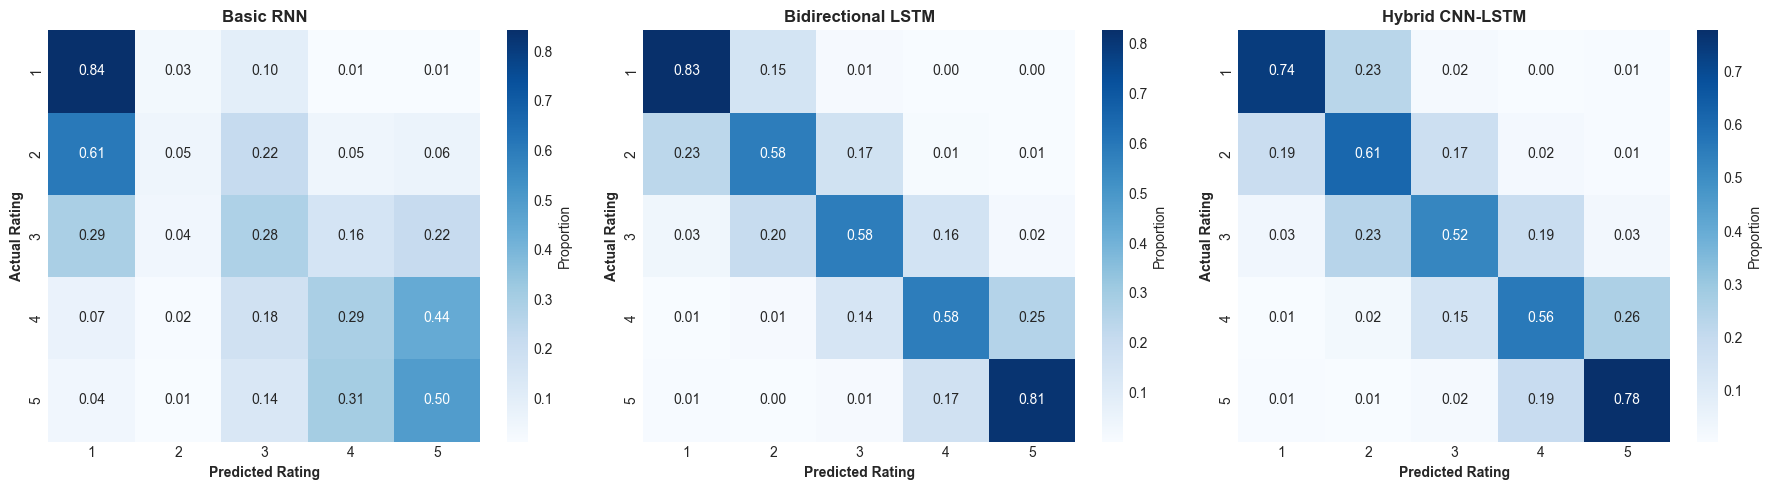

Plot saved: 12_dl_confusion_matrices.png


In [20]:
# Visualize confusion matrices
print("\n" + "=" * 80)
print("CONFUSION MATRICES")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, preds) in enumerate(models_results):
    cm = confusion_matrix(y_test_np, preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
               xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5],
               ax=axes[idx], cbar_kws={'label': 'Proportion'})
    axes[idx].set_xlabel('Predicted Rating', fontweight='bold')
    axes[idx].set_ylabel('Actual Rating', fontweight='bold')
    axes[idx].set_title(model_name, fontweight='bold')

plt.tight_layout()
plt.savefig('../Outputs/Plots/12_dl_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: 12_dl_confusion_matrices.png")


TRAINING CURVES


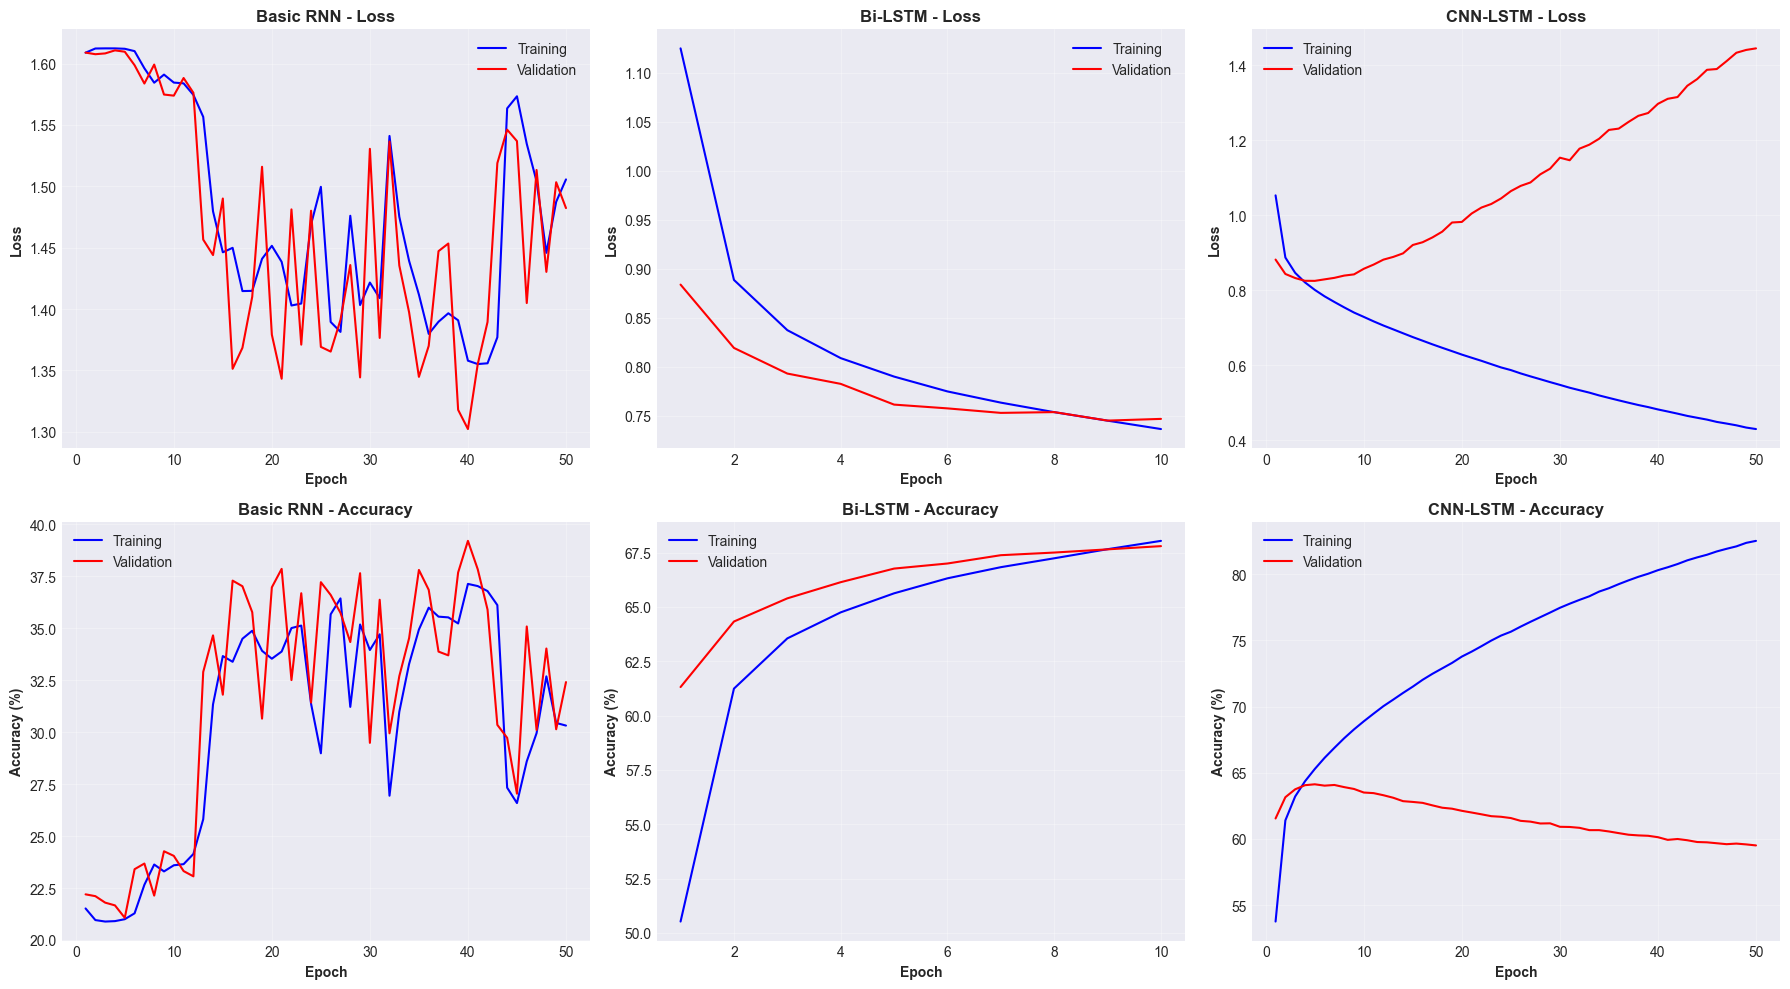

Plot saved: 13_training_curves.png


In [21]:
# Plot training curves
print("\n" + "=" * 80)
print("TRAINING CURVES")
print("=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Training history for each model
training_data = [
    ('Basic RNN', rnn_train_losses, rnn_val_losses, rnn_train_accs, rnn_val_accs),
    ('Bi-LSTM', lstm_train_losses, lstm_val_losses, lstm_train_accs, lstm_val_accs),
    ('CNN-LSTM', cnn_lstm_train_losses, cnn_lstm_val_losses, cnn_lstm_train_accs, cnn_lstm_val_accs)
]

for idx, (name, train_loss, val_loss, train_acc, val_acc) in enumerate(training_data):
    epochs = range(1, len(train_loss) + 1)
    
    # Loss
    axes[0, idx].plot(epochs, train_loss, 'b-', label='Training')
    axes[0, idx].plot(epochs, val_loss, 'r-', label='Validation')
    axes[0, idx].set_xlabel('Epoch', fontweight='bold')
    axes[0, idx].set_ylabel('Loss', fontweight='bold')
    axes[0, idx].set_title(f'{name} - Loss', fontweight='bold')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1, idx].plot(epochs, [acc*100 for acc in train_acc], 'b-', label='Training')
    axes[1, idx].plot(epochs, [acc*100 for acc in val_acc], 'r-', label='Validation')
    axes[1, idx].set_xlabel('Epoch', fontweight='bold')
    axes[1, idx].set_ylabel('Accuracy (%)', fontweight='bold')
    axes[1, idx].set_title(f'{name} - Accuracy', fontweight='bold')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../Outputs/Plots/13_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: 13_training_curves.png")

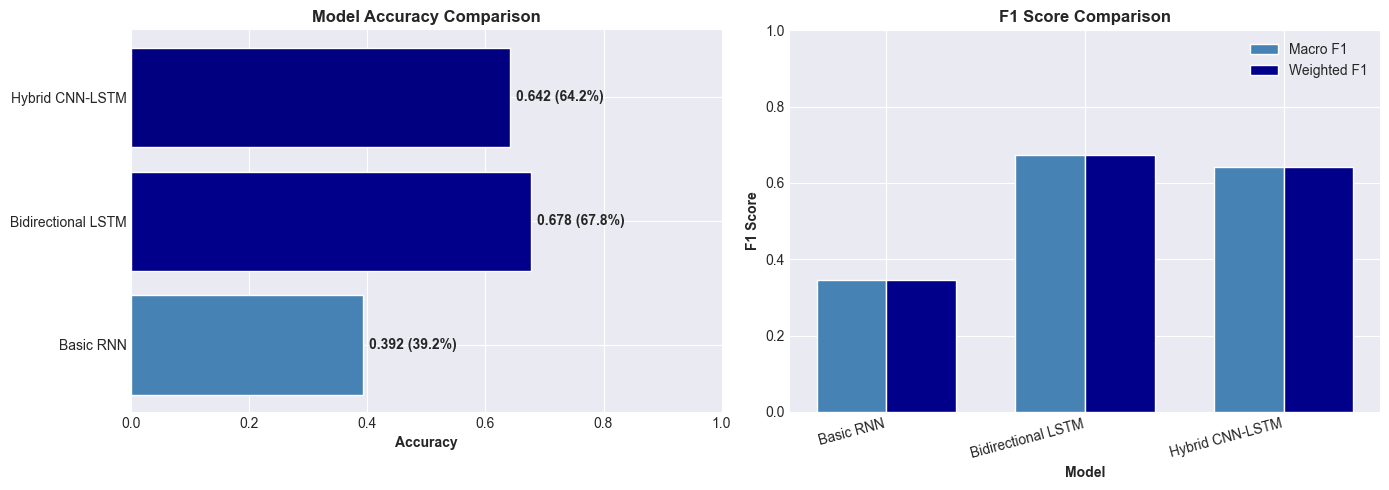

Plot saved: 14_dl_model_comparison.png


In [22]:
# Model comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].barh(results_df['Model'], results_df['Accuracy'], 
            color=['steelblue', 'darkblue', 'navy'])
axes[0].set_xlabel('Accuracy', fontweight='bold')
axes[0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0].set_xlim(0, 1)

for i, v in enumerate(results_df['Accuracy']):
    axes[0].text(v + 0.01, i, f'{v:.3f} ({v*100:.1f}%)', va='center', fontweight='bold')

# F1 Score comparison
x = np.arange(len(results_df))
width = 0.35

axes[1].bar(x - width/2, results_df['F1 (Macro)'], width, label='Macro F1', color='steelblue')
axes[1].bar(x + width/2, results_df['F1 (Weighted)'], width, label='Weighted F1', color='darkblue')
axes[1].set_xlabel('Model', fontweight='bold')
axes[1].set_ylabel('F1 Score', fontweight='bold')
axes[1].set_title('F1 Score Comparison', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('../Outputs/Plots/14_dl_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: 14_dl_model_comparison.png")

## 7. Save Results

In [23]:
# Save all results
print("=" * 80)
print("SAVING RESULTS")
print("=" * 80)

# Save results CSV
results_df.to_csv('../Outputs/dl_model_comparison.csv', index=False)
print("Saved: dl_model_comparison.csv")

# Save vocabulary
with open('../Outputs/Models/vocab.pkl', 'wb') as f:
    pickle.dump({'word2idx': word2idx, 'idx2word': idx2word}, f)
print("Saved: vocab.pkl")

# Save hyperparameters
import json
with open('../Outputs/dl_hyperparameters.json', 'w') as f:
    json.dump(hyperparams, f, indent=2)
print("Saved: dl_hyperparameters.json")

# Save detailed results
detailed_results = {
    'models': [],
    'best_model': best_model_name,
    'best_accuracy': float(best_accuracy)
}

for model_name, preds in models_results:
    model_results = {
        'name': model_name,
        'accuracy': float(accuracy_score(y_test_np, preds)),
        'f1_macro': float(f1_score(y_test_np, preds, average='macro')),
        'f1_weighted': float(f1_score(y_test_np, preds, average='weighted')),
        'per_class_report': classification_report(y_test_np, preds, 
                                                  target_names=star_names, 
                                                  output_dict=True)
    }
    detailed_results['models'].append(model_results)

with open('../Outputs/dl_detailed_results.json', 'w') as f:
    json.dump(detailed_results, f, indent=2)
print("Saved: dl_detailed_results.json")

print("\n" + "="*80)
print("ALL RESULTS SAVED SUCCESSFULLY")
print("="*80)

SAVING RESULTS
Saved: dl_model_comparison.csv
Saved: vocab.pkl
Saved: dl_hyperparameters.json
Saved: dl_detailed_results.json

ALL RESULTS SAVED SUCCESSFULLY
